# Structs and Objects

We have seen a number of different *types* in Julia, such as `Int64`, `Float64`, `Array{Float64,2}`, etc. Now we will learn how to create new types, how to use them to store data, and how to define new functions (methods) and operators on them. This is closely related to the concept of *object orientation* in other computer languages.

## Composite types

The keyword `struct` is used to create a so-called composite type, that is, a new user-defined type.
The type is given a name, and a list of *fields* (or *attributes*) which are names that will be used
as variables to store data for objects of the new type.

As an example, we create a new type named `MyPoly` for storing and operating on polynomials.
The fields will be an array of coefficients `c`, and a character `var` to denote the name of the dependent
variable.

A variable name can also be followed by `::` and a type. This will enforce this type and give an
error otherwise, which can be useful to ensure the new composite type is used correctly. In our
example, we specify that `c` must be of type `Vector` (however we do not specify which types of
 numbers in the vector). We also specify that `var` must be a `Char`.

In [1]:
struct MyPoly
    c::Vector
    var::Char
end

The coefficients `c` will represent the polynomial in the standard monomial form:

$$
p(x) = \sum_{k=0}^d c_{n-k}x^k
$$

where $c$ is the array of coefficients, $d$ is the polynomial degree, and $n$ is the length of the array $c$. Note that we allow for $n$ to be greater than the number of required coefficients $d+1$, and that the coefficients are stored in reverse order (that is, highest exponents come first).

With this definition, we can create a so-called *instance* of the type
(or *object*) by
providing the values for each of the fields. For example, the polynomial
$p(x) = 3x^2 - 5x + 2$ can be created as:

In [2]:
p = MyPoly([3,-5,2], 'x')

MyPoly([3, -5, 2], 'x')

Note that by default, Julia will print the object using the type name and a list of the field values. Later we will override this and create a specialized output function.

You can define other ways to specify (or initialize) a polynomial using a so-called *constructor*,
which is a function that is called when a type is initiated. For example, if you want to allow for
creating a polynomial using only a coefficient array `c` but using the default value `x` for the `var`
field, you can add a so-called outer constructor as shown below:

In [3]:
MyPoly(c) = MyPoly(c, 'x')

MyPoly

At this point, the struct `p` does not do anything besides simply storing the variables `c` and `var`. They can be accessed using a `.` notation:

In [4]:
p.c

3-element Vector{Int64}:
  3
 -5
  2

In [5]:
p.var

'x': ASCII/Unicode U+0078 (category Ll: Letter, lowercase)

However, structs in Julia are *immutable* which means that once created, you can not change their contents. This is different from many other language, and there are some good reasons for this design. If you need to change the variables in a struct, or even add new fields, simply use the keyword `mutable struct` instead of `struct`. However, here we will stay with a standard struct, since in our example we will only modify the polynomials coefficients `c`. This is an exception which actually is allowed, since the variable `c` is itself a mutable object and its content can be changed.

For example, if you want to change the polynomial to $p(x) = -x^3 + 3x^2 - 5x + 2$ you can *not* change the actual array in `c`:

```julia
p.c = [-1,3,-5,2]  # Error: Immutable struct
```

but you can change the content in the existing array `c`:

In [6]:
resize!(p.c, 4)
p.c[1:4] = [-1,3,-5,2]
p

MyPoly([-1, 3, -5, 2], 'x')

Of course, another option is to simply create a new instance of the `MyPoly` type:

In [7]:
p = MyPoly([-1,3,-5,2], p.var)

MyPoly([-1, 3, -5, 2], 'x')

## Functions on types

We can easily define functions on new types, by passing the objects as arguments or return values.
For example, we can easily define a function that multiplies a polynomial $p(x)$ by $x$ in the
following way:

In [8]:
function times_x(p)
   return MyPoly(vcat(p.c,0), p.var) 
end

times_x(p)

MyPoly([-1, 3, -5, 2, 0], 'x')

However, this function should only work if you pass a `MyPoly` type to it. In Julia you can write functions that operate differently on different types. A function which defines the behavior for a specific combination or number of arguments is called a *method*.

A function which is specialized for a certain type can be created using a *type declaration* with the `::` operator. As an example, we create a `degree` function to find the degree $d$. The implementation
is straight-forward, we simply search the for the first (highest degree) non-zero
coefficient. Note that we define the degree of the zero polynomial to be -1.

In [9]:
function degree(p::MyPoly)
    ix1 = findfirst(p.c .!= 0)
    if ix1 == nothing
        return -1
    else
        return length(p.c) - ix1
    end
end

degree (generic function with 1 method)

In [10]:
println(degree(MyPoly([0,0,0,0,0])))
println(degree(MyPoly([0,0,0,0,1])))
println(degree(MyPoly([0,0,0,1,0])))
println(degree(MyPoly([1,0,0,0,0])))

-1
0
1
4


By specializing the `degree` function to the `MyPoly` type, we can now use the same function name for other combinations or types, that is, to implement other methods. This is also called *overloading*.

In [11]:
function degree(p::Int)
    println("degree function called with Int argument")
end

function degree(p)
    println("degree function called with any other argument")
end

degree(1.234)
degree([1,2])
degree(-123)
degree(MyPoly([1,2,3]))

degree function called with any other argument
degree function called with any other argument
degree function called with Int argument


2

## Customized printing

Julia provides a special function `show` in the `Base` package, which can be overloaded to change how objects of a new type are printed. For our polynomials, instead of showing the array of coefficients `c` and the name of the independent variable `var`, we will write it as a polynomial in standard math notation.

The details of this functions do not matter much, it mostly needs to deal with certain special cases to print polynomials correctly. The main point is that it will *only be called* for objects of type `MyPoly`.

In [12]:
function Base.show(io::IO, p::MyPoly)
    d = degree(p)
    print(io, "MyPoly: ")
    for k = d:-1:0
        coeff = p.c[end-k]
        if coeff == 0 && d > 0
            continue
        end
        if k < d
            if isa(coeff, Real)
                if coeff > 0
                    print(io, " + ")
                else
                    print(io, " - ")
                end
                coeff = abs(coeff)
            else
                print(io, " + ")
            end
        end
        if isa(coeff, Real)
            print(io, coeff)
        else
            print(io, "($coeff)")
        end
        if k == 0
            continue
        end
        print(io, "⋅", p.var)
        if k > 1
            print(io, "^", k)
        end
    end
end

In [13]:
p

MyPoly: -1⋅x^3 + 3⋅x^2 - 5⋅x + 2

In [14]:
MyPoly([-1.234,0,0,0,4.321], 's')

MyPoly: -1.234⋅s^4 + 4.321

## Callable objects

One basic operation to perform on a polynomial is evaluation, that is, for a given number $x$ compute $p(x)$. We will implement this using *Horner's rule*:

$$
\begin{align}
p(x) &= a_nx^n + a_{n-1} x^{n-1} + \cdots + a_0 \\
     &= ((a_n + xa_{n-1})x + \cdots)x + a_0
\end{align}
$$

While we could implement this in a function with a new name, for example, `polyval`, Julia allows the definition of a method which behaves like a function evaluating the polynomial:

In [15]:
function (p::MyPoly)(x)
    d = degree(p)
    v = p.c[end-d]
    for cc = p.c[end-d+1:end]
        v = v*x + cc
    end
    return v
end

In [16]:
println(p(1))
println(p(1.234))
println(p.([1,-2,1.3]))  # Note: Broadcasting automatically defined

-1
-1.4808129039999995
[-1.0, 32.0, -1.6270000000000002]


## Plotting

Using the evaluation functionality, we can easily implement plotting of polynomials. Again we reuse the name `plot` which is already used in the `PyPlot` package, but we specialize it to our `MyPoly` type:

In [17]:
using PyPlot
function PyPlot.plot(p::MyPoly, xlim=[-2,2])
    xx = collect(range(xlim[1], xlim[2], length=100))
    plot(xx, p.(xx))
    xlabel(string(p.var))
end

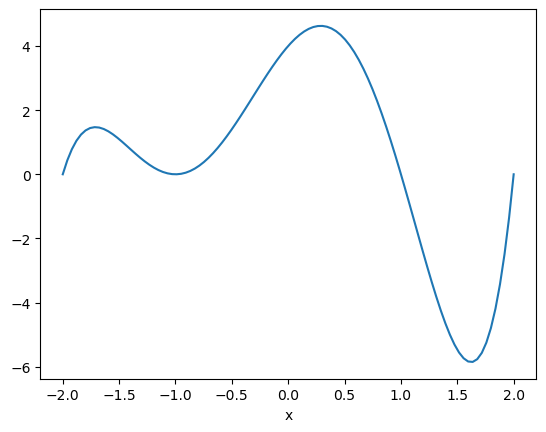

MyPoly: 1⋅x^5 + 1⋅x^4 - 5⋅x^3 - 5⋅x^2 + 4⋅x + 4

In [18]:
p = MyPoly([1,1,-5,-5,4,4])
plot(p)
p

## Operator overloading

Operators such as `+` can also be overloaded for new types, by specializing the function definition. These operators are so fundamental to the language itself that they are part of the `Base` package. This special package is automatically included by Julia, so there is no need to call `using Base` before using any of its functionality or specify `Base.func_name()` when calling one of its functions. However, when overloading a function in this package, we must still specify that the function is a part of this package with the usual syntax `Base.func_name()`. 

Adding polynomials is of course easy, we simply add the coefficients. However, for our implementation we first need to make sure the coefficient vectors are long enough to contain the sum:

In [19]:
function Base.:+(p1::MyPoly, p2::MyPoly)
    if p1.var != p2.var
        error("Cannot add polynomials of different independent variables.")
    end
    d1 = length(p1.c)
    d2 = length(p2.c)
    d = max(d1,d2)
    c = [fill(0, d-d1); p1.c] + [fill(0, d-d2); p2.c]
    return MyPoly(c, p1.var)
end

In [20]:
println(p)
println(p + p)
println(p + MyPoly([1.1,2.2]))
println(p + MyPoly([1], 's')) # will trigger our error message

MyPoly: 1⋅x^5 + 1⋅x^4 - 5⋅x^3 - 5⋅x^2 + 4⋅x + 4
MyPoly: 2⋅x^5 + 2⋅x^4 - 10⋅x^3 - 10⋅x^2 + 8⋅x + 8
MyPoly: 1.0⋅x^5 + 1.0⋅x^4 - 5.0⋅x^3 - 5.0⋅x^2 + 5.1⋅x + 6.2


LoadError: Cannot add polynomials of different independent variables.

Subtraction is easiest done by overloading the `-` operator and reusing the implementation of `+`:

In [21]:
function Base.:-(p1::MyPoly, p2::MyPoly)
    return p1 + MyPoly(-p2.c)
end

Similarly with scalar multiplication, we overload `*`. Note that we do not specify the type of the first scalar argument `a`, it is assumed that it is a regular number (not a `MyPoly`) object. We also define multiplication in the reverse order, by reusing the same function (since we know that it commutes).

In [22]:
function Base.:*(a, p::MyPoly)
    newc = a * p.c
    return MyPoly(newc, p.var)
end

function Base.:*(p::MyPoly, a)
    return a*p
end

Using the overloaded operators `+`, `-`, and `*` (for scalars), we can perform many polynomial operations:

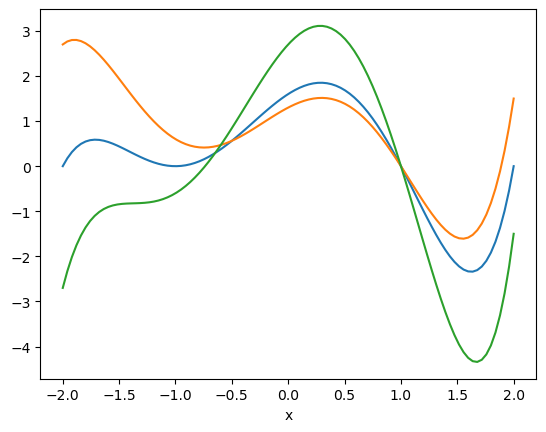

In [23]:
p1 = 0.4p
p2 = p1 - .3*MyPoly([-2,1,1])
p3 = -1p2 + p
plot.([p1,p2,p3]);

## Generic programming

In the examples above we have specialized many functions and operators to work in a specific way for objects of type `MyPoly`. However, note the advantages of *not* limiting the type of a variable or function argument to be of a certain type. For example, in the definition of `MyPoly` we did not specify that the coefficients `c` should be of e.g. integer or floating point types (in fact our examples used both). This means our functions work perfectly fine also for rational coefficients and arguments:

In [24]:
p = MyPoly([1, -2//3, 6//7])

MyPoly: 1//1⋅x^2 - 2//3⋅x + 6//7

In [25]:
p.([1, -7//2])

2-element Vector{Rational{Int64}}:
   25//21
 1297//84

and for complex:

In [26]:
p = MyPoly([1, im, -1, -im, 1])

MyPoly: (1 + 0im)⋅x^4 + (0 + 1im)⋅x^3 + (-1 + 0im)⋅x^2 + (0 - 1im)⋅x + (1 + 0im)

In [27]:
p.([0, im, -1 - im])

3-element Vector{Complex{Int64}}:
  1 + 0im
  5 + 0im
 -2 + 1im

or for `BigFloat`:

In [28]:
p = MyPoly(collect(-1.5:3.5))

MyPoly: -1.5⋅x^5 - 0.5⋅x^4 + 0.5⋅x^3 + 1.5⋅x^2 + 2.5⋅x + 3.5

In [29]:
p(BigFloat(-π))

405.2722682884305251107738095974542912801020079018409933037640550322547603287204